In [1]:
import pickle as pck
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functions_PDF import pdf_creator3x3, pdf_creator3x3_indexs, pdf_creator3x3_verticals
from functions_MuonsNSAMP1 import DataFrame_muons, pixel_rot

import skimage as sk
import scipy.ndimage as nd
import numpy.ma as ma

# from ROOT import TFile, TTree

## Configuración del estilo de las imágenes
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',
})

colorbar='jet'


In [2]:
######## Nueva definición de la elipcidad ############
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_dEDL_0_SIZE_250x539_KeV_.pkl'
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_0_SIZE_250x539_KeV_n.pkl'
# path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1100_SIZE_250x539_KeV_n.pkl'
path = './Diccionarios_Espetro_Muones/dict_muons_NSAMP324_Extensions_1_2_4_NIMGS_393_SOL_0.65_ELIP_0.65_NSIGMAS_13_DEDL_1400_SIZE_250x539_KeV_n.pkl'



histogram = open(path, 'rb')
data_histogram = pck.load(histogram)
histogram.close()

#### Visualizar las keys del diccionario ####
print('Las unidades de los datos están en: ', data_histogram['Energy_Units'])
print('Llaves principales del diccionario: ', data_histogram.keys())
print('Llaves secuandarias por extensión: ', data_histogram['extension_1'].keys(), end='\n\n')
# print(type(data_histogram['extension_1']['all_events']))
# data_muons_extension_1 = data_histogram['extension_1']
# data_muons_extension_2 = data_histogram['extension_2']
# data_muons_extension_4 = data_histogram['extension_4']
Ext = 1

n_muons = data_histogram['All_Muons_Detected']
print('Se detectaron ', n_muons, ' muones (contando las 3 extensiones)')
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

Las unidades de los datos están en:  2
Llaves principales del diccionario:  dict_keys(['Num_Images', 'All_Muons_Detected', 'Energy_Units', 'Elipticity', 'Solidity', 'Fit_errors', 'extension_1', 'extension_2', 'extension_4'])
Llaves secuandarias por extensión:  dict_keys(['charge', 'deltaEL', 'deltaL', 'all_events', 'theta', 'phi', 'gain', 'elip', 'sol', 'all_events_elip', 'all_events_sol', 'datamasked'])

Se detectaron  2833  muones (contando las 3 extensiones)


,Gain (ADU/e-),Solidity,Elipticity,Theta (Deg),Phi (Deg),Charge (KeV),l (cm),dEdL (KeV/cm)
Muon ID,,,,,,,,
0,213.358468,0.803846,0.847013,41.638509,9.372529,216.07663,0.097009,2227.38254


Shape (Y, X):  (11, 43)


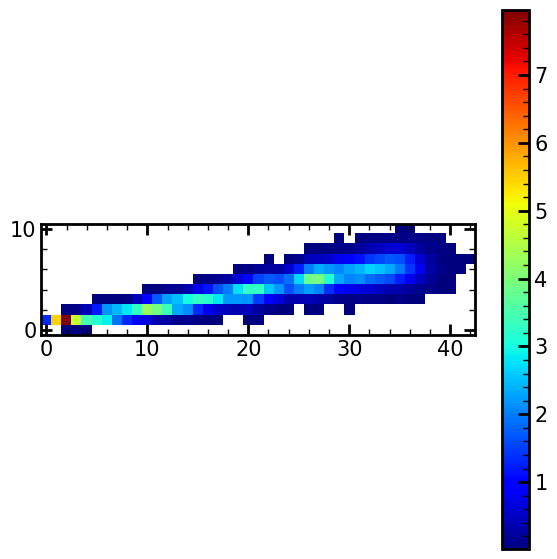

In [3]:
n_label = 0

fig, axs = plt.subplots(ncols=1, nrows=1, figsize=[7,7])
x1 = axs.imshow(list_datamask[n_label], cmap=colorbar)
fig.colorbar(x1, ax=axs)

display(DF_muons.iloc[[n_label]])
print('Shape (Y, X): ', list_datamask[n_label].shape)
plt.show()

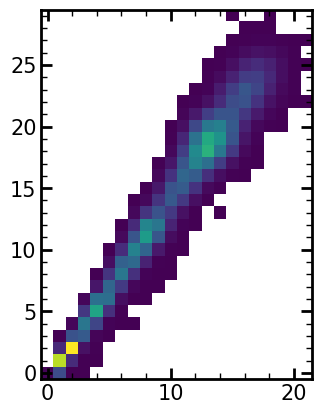

In [32]:
### Se crea el dataframe y se selecciona un rango de datos ###
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

plt.imshow(list_newmatrix[2])
plt.show()

In [34]:
list_phi_ext1 = data_histogram['extension_1']['phi']
list_mask_rot = []

list_listsnxny = []

for index in list_indexs[:]:
    datamask = list_datamask[index]
    ylen, xlen = datamask.shape
    list_nxny = []

    data_mask_zeros = np.empty((ylen + 90, xlen+50))
    data_mask_zeros[:] = 0
    ylen_zeros, xlen_zeros = data_mask_zeros.shape
    # print(data_mask_zeros.shape)
    
    ### Angle rot ##
    phi_rot = np.pi/2 - list_phi_ext1[index]
    # print(phi_rot, phi_rot + list_phi_ext1[index])

    # print('shape original: ', xlen, ylen)
    # print('shape zeros: ', xlen_zeros, ylen_zeros)

    for y_bin in range(0, ylen):
        for x_bin in range(0, xlen):
            if datamask[y_bin][x_bin] != 0:
                nx, ny = pixel_rot(x_bin=x_bin, x0=0, y_bin=y_bin, y0=0, theta= phi_rot)
                list_nxny.append((nx + 10, ny))
                # print(nx, ny)
                data_mask_zeros[ny][nx+10] = datamask[y_bin][x_bin]

    list_listsnxny.append(list_nxny)
    label_img, nlabels_img = sk.measure.label(data_mask_zeros > 0, connectivity=2, return_num=True)
    loc = nd.find_objects(label_img == 1)[0]
    mask_rot = np.invert(label_img==1)
    data_mask_rot = ma.masked_array(data_mask_zeros, mask_rot)
    # data_mask_rot = ma.masked_array(data_mask_zeros[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop], mask_rot[loc[0].start:loc[0].stop, loc[1].start:loc[1].stop])

    list_mask_rot.append(data_mask_rot)
    # print('Shape rot: ', data_mask_rot.shape[1], data_mask_rot.shape[0])
    
    # plt.imshow(data_mask_rot)
    # plt.show()
#     

In [25]:
# display(list_listsnxny[1]
dict_reps = {}
for duple in list_listsnxny[1]:
    dict_reps[duple] = dict_reps.get(duple, 0) + 1

# display(dict_reps)
n_valuesrep = 0
for value in dict_reps:
    if dict_reps[value]>1:
        n_valuesrep += 1
        print(value, ': ', dict_reps[value])

print('Elements with more reps: ', n_valuesrep)

(10, 0) :  3
(10, 1) :  2
(12, 2) :  2
(10, 3) :  2
(14, 5) :  2
(10, 4) :  2
(10, 5) :  3
(10, 6) :  2
(11, 7) :  2
(10, 7) :  2
(12, 8) :  2
(10, 8) :  2
(13, 10) :  2
(10, 9) :  2
(14, 11) :  2
(10, 10) :  2
(10, 11) :  2
(10, 12) :  3
(10, 14) :  2
(12, 15) :  2
(10, 15) :  2
(10, 16) :  2
(10, 17) :  2
(10, 18) :  2
(10, 19) :  2
(11, 20) :  2
(10, 20) :  2
(10, 21) :  3
(13, 23) :  2
(10, 22) :  2
(10, 23) :  2
(11, 24) :  2
(10, 25) :  3
(10, 26) :  2
(10, 27) :  2
(12, 28) :  2
(10, 28) :  2
(11, 29) :  2
(10, 30) :  2
(10, 31) :  2
(9, 31) :  2
(10, 32) :  2
(11, 33) :  2
(10, 33) :  2
(10, 34) :  2
(13, 36) :  2
(10, 35) :  2
(9, 36) :  2
(10, 36) :  2
(10, 38) :  3
(10, 39) :  2
(11, 40) :  2
(12, 41) :  2
(10, 41) :  2
(8, 41) :  2
(13, 43) :  2
(14, 44) :  2
(9, 42) :  2
(10, 43) :  2
(10, 44) :  3
(11, 46) :  2
(10, 46) :  2
(10, 47) :  2
(10, 48) :  2
Elements with more reps:  64


In [6]:
PDF_rot_name = 'Muons_PHI_BETWEEN_0-90_EXT1_DEDL_1400_rot.pdf'
pdf_creator3x3_verticals(pdf_name=PDF_rot_name, list_pixelmatrix=list_mask_rot)

The PDF is being created
259  muons will be display
Done


0

# Creación de PDF para todos los muones de una extensión

In [ ]:
n_label = 100

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=[7,7])
axs[0,0].imshow(list_datamask[n_label], cmap=colorbar)
axs[0,0].set_title('ID: ' + str(n_label))

axs[0,1].imshow(list_datamask[n_label+1], cmap=colorbar)
axs[0,1].set_title('ID: ' + str(n_label+1))

axs[0,2].imshow(list_datamask[n_label+2], cmap=colorbar)
axs[0,2].set_title('ID: ' + str(n_label+2))

axs[1,0].imshow(list_datamask[n_label+3], cmap=colorbar)
axs[1,0].set_title('ID: ' + str(n_label+3))

axs[1,1].imshow(list_datamask[n_label+4], cmap=colorbar)
axs[1,1].set_title('ID: ' + str(n_label+4))

axs[1,2].imshow(list_datamask[n_label+5], cmap=colorbar)
axs[1,2].set_title('ID: ' + str(n_label+5))

axs[2,0].imshow(list_datamask[n_label+6], cmap=colorbar)
axs[2,0].set_title('ID: ' + str(n_label+6))

axs[2,1].imshow(list_datamask[n_label], cmap=colorbar)
axs[2,1].set_title('ID: ' + str(n_label+7))

axs[2,2].imshow(list_datamask[n_label+8], cmap=colorbar)
axs[2,2].set_title('ID: ' + str(n_label+8))

plt.tight_layout()
plt.show()

In [ ]:
Ext = 1  # Only change this value and the PDF_name

DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

# list_datamask = list_datamask[:50]
print('Len: ', len(list_datamask))
### Creación del PDF con el nombre ##
PDF_name = 'Prueba1.pdf'
c = canvas.Canvas(PDF_name, letter)
w, h = A4 ## dimensiones del formato

### Imagen provicional ###
path_image = 'Perfil_Muon.jpg'
color_matrix = [0.4, 0.4470, 0.2410]
coord3x3 = [[0,0],[0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2]]
n_last_events = 0

# for extension in (1,2,4):
# c.drawString(50, h - 50, 'Extensión ' + str(Ext)) 
n_muonstot = len(list_datamask)
n_last_events = 0
n_events = 0


fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix) ## Las hojas tendrán 9 muones
num_pages = 0
# c.showPage()

if (n_muonstot%9) == 0:
    # print('Hola')
    for index in range(0, len(list_datamask)):
        n_muonstot = n_muonstot - 1
        n_events = n_events + 1
        if n_events < 10: 
            # print('n_events: ', n_events)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(list_datamask[index], cmap = colorbar)
            axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_title('ID: ' + str(index))

            if n_events == 9:
                n_events = 10
        
        if n_events == 10:
            n_events = 0
            num_pages = num_pages + 1
            fig.savefig(path_image)
            img = ImageReader(path_image)

            # Obtener el ancho y alto de la imagen.
            img_w, img_h = img.getSize()

            # h - img_h es el alto de la hoja menos el alto de la imagen.
            c.drawImage(img, w - img_w + 10, h - img_h - 90)
            c.drawString(w/2, 40, str(num_pages))
            c.showPage()
            # plt.imshow(event)
            # plt.show()
            plt.close()
            ! rm Perfil_Muon.jpg

            fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix)

elif (n_muonstot%9) != 0:
    # print('No Hola')
    Resto = n_muonstot%9

    for index in range(0, len(list_datamask)):
        n_muonstot = n_muonstot - 1
        n_events = n_events + 1

        if n_muonstot >= Resto:
            print('Primera condicion')
            if n_events < 10: 
                # print('n_events: ', n_events)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].imshow(list_datamask[index], cmap = colorbar)
                axs[coord3x3[n_events - 1][0],coord3x3[n_events - 1][1]].set_title('ID: ' + str(index))

                if n_events == 9:
                    n_events = 10

            if n_events == 10:
                print('Estoy aqui')
                n_events = 0
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()
                print('Aqui ', img_w)

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w+10, h - img_h-90)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [6,6], facecolor = color_matrix)

        elif n_muonstot<Resto:
            print('Segunda condicion')
            n_last_events = n_last_events + 1

            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].imshow(list_datamask[index], cmap=colorbar)
            axs[coord3x3[n_last_events - 1][0],coord3x3[n_last_events - 1][1]].set_title('ID: ' + str(index))

            if n_muonstot == 0:
                # plt.show()
                num_pages = num_pages + 1
                fig.savefig(path_image)
                img = ImageReader(path_image)

                # Obtener el ancho y alto de la imagen.
                img_w, img_h = img.getSize()

                # h - img_h es el alto de la hoja menos el alto de la imagen.
                c.drawImage(img, w - img_w + 50, h - img_h - 60)
                c.drawString(w/2, 40, str(num_pages))
                c.showPage()
                # plt.imshow(event)
                # plt.show()
                plt.close()
                ! rm Perfil_Muon.jpg

                fig, axs = plt.subplots(ncols= 3, nrows= 3, figsize = [10,10], facecolor = color_matrix)
        
plt.close()
c.save()

Len:  1361
No Hola
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Primera condicion
Estoy aqui
Aqui  600
Primera condicion
Primera condicion
Primera condicion
Primera cond

# Creción de PDFs para un rango de datos

In [ ]:
Ext = 1
DF_muons, list_datamask = DataFrame_muons(data_histogram, extension=Ext)

list_newmatrix = []
list_indexs =[]
# range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(165, 195)]
range_in_phi = DF_muons[DF_muons['Phi (Deg)'].between(0, 90)]

for index in range_in_phi.index:
    # print(index)
    list_newmatrix.append(list_datamask[index])
    list_indexs.append(index)

# plt.imshow(list_newmatrix[0])
PDF_name = 'Muons_PHI_BETWEEN_0-90_EXT1_DEDL_1400.pdf'
pdf_creator3x3_indexs(PDF_name, list_newmatrix, list_indexs)
